In [6]:
from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os

In [8]:
max_dataset_size = 100
waveform_length = 72;
nb_of_elements = 25000;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
root_folder = os.path.dirname(os.getcwd())
path_to_recording= path.join(root_folder,'data/recording_datasets/eeg_recording_dataset.npy');
path_to_ground_truth_data = path.join(root_folder,'data/recording_datasets/eeg_ground_truth_dataset.npy');
path_to_train_data = path.join(root_folder,'data/train_data.npy');
path_to_train_labels = path.join(root_folder,'data/train_labels.npy');
path_to_noise_data = path.join(root_folder,'data/noise_data.npy');
path_to_mean_std = path.join(root_folder,'data/mean_std.npy');
sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn

In [9]:
noise_indices = cnn.GetNoiseIndices(path_to_recording, path_to_ground_truth_data, waveform_length, nb_of_elements);



In [10]:
noise_class = torch.zeros(1, noise_indices.nelement(), dtype= torch.int);
noise_data = torch.cat((noise_indices, noise_class), 0);


In [11]:
np.save(path_to_noise_data, noise_data.numpy());

In [12]:
%pdb on
dataset_spikes = cnn.GenerateDataset(path_to_recording, path_to_ground_truth_data, waveform_length, max_dataset_size);


Automatic pdb calling has been turned ON
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  -18
shift_to:  19
shift_step:  1
shift_indexes:  tensor([-18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
         -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
         10,  11,  12,  13,  14,  15,  16,  17,  18], dtype=torch.int32)
snr_ratio:  None
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
dataset len:  94276


In [ ]:
dataset_noise = cnn.GenerateDataset(path_to_recording, path_to_noise_data, waveform_length, max_dataset_size);


========== 1 generation ==========
temp_dataset_len:  0
shift_from:  -18
shift_to:  19
shift_step:  4
shift_indexes:  tensor([-18, -14, -10,  -6,  -2,   2,   6,  10,  14,  18], dtype=torch.int32)
snr_ratio:  None
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]


In [ ]:
dataset_size =  dataset_spikes.__len__() if dataset_spikes.__len__() < dataset_noise.__len__() else  dataset_noise.__len__()

In [ ]:
# convers to np array
np_data_spikes = np.zeros((dataset_size, 1, waveform_length));
for i, (data, target) in enumerate(dataset_spikes):
  np_data_spikes[i, :] = data.numpy();
  if(i + 1 == dataset_size):
    break;

In [78]:

    

# removes spikes that have mutiple spikes in waveform
spike_argmax = np.argmax(abs(np_data_spikes), 2)
over_treshold = waveform_length // 2 + waveform_length // 4
under_treshold = waveform_length // 2 - waveform_length // 4
is_valid_train_data = ((spike_argmax >= under_treshold) & (spike_argmax <= over_treshold)).ravel()
np_data_spikes = np_data_spikes[is_valid_train_data, :, :]
dataset_size = np_data_spikes.shape[0]
np_classes_spikes = np.ones(dataset_size)

np_data_noise = np.zeros((dataset_size, 1, waveform_length));
np_classes_noise = np.zeros(dataset_size)
counter = 0;
for i, (data, target) in enumerate(dataset_noise):
    np_data_noise[counter, :] = data.numpy()
    counter = counter + 1;
    if(i + 1 == dataset_size):
        break;
    

    


In [79]:
print(np_data_noise.shape)
print(np_data_spikes.shape)


(1938016, 1, 72)
(1938016, 1, 72)


In [80]:
dataset = np.concatenate((np_data_spikes, np_data_noise), 0);

In [81]:
labels = np.concatenate((np_classes_spikes, np_classes_noise), 0); 

In [83]:
np.save(path_to_train_data, dataset)
np.save(path_to_train_labels, labels)


In [84]:
mean = (np.mean(np_data_spikes))
std = (np.std(np_data_spikes))
np.save(path_to_mean_std, [mean, std])

print(mean)
print(std)

-0.4336226370473097
1.821706751474446


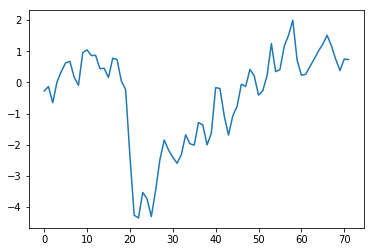

In [115]:
import matplotlib.pyplot as plt
rnd = np.random.randint(0, np_data_spikes.shape[0]);
plt.plot(np_data_spikes[rnd, 0, :])


KeyboardInterrupt: 

> /home/vtpc/Documents/Alvils/spike-sorting/custom_resnet/CustomResnet.py(361)__getitem__()
    359 
    360     def __getitem__(self, idx):
--> 361         spike = self.data[idx, :];
    362         label = self.labels[idx];
    363         return spike, label

ipdb> i
*** NameError: name 'i' is not defined
ipdb> up
> /home/vtpc/.local/lib/python3.5/site-packages/torch/utils/data/dataset.py(81)__getitem__()
     79         else:
     80             sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]
---> 81         return self.datasets[dataset_idx][sample_idx]
     82 
     83     @property

ipdb> up
> /home/vtpc/.local/lib/python3.5/site-packages/torch/utils/data/dataset.py(81)__getitem__()
     79         else:
     80             sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]
---> 81         return self.datasets[dataset_idx][sample_idx]
     82 
     83     @property

ipdb> up
> /home/vtpc/.local/lib/python3.5/site-packages/torch/utils/data/dataset.py(81)__getitem_